In [1]:
import numpy as np

from tensorflow.examples.tutorials.mnist import input_data
from autodiff import *

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

batch = 50
iterations = 500 

sess = Session()

X = PlaceholderOp((batch, 28, 28, 1), sess, False)
Y_ = PlaceholderOp((batch, 10), sess, False)
P = PlaceholderOp((), sess, False)
W_CONV1 = PlaceholderOp((5, 5, 1, 32), sess)
B_CONV1 = PlaceholderOp((32,), sess)
W_CONV2 = PlaceholderOp((5, 5, 32, 64), sess)
B_CONV2 = PlaceholderOp((64,), sess)
W_FC1 = PlaceholderOp((7 * 7 * 64, 1024), sess)
B_FC1 = PlaceholderOp((1024,), sess)
W_FC2 = PlaceholderOp((1024, 10), sess)
B_FC2 = PlaceholderOp((10,), sess)

CONV1 = Conv2dOp(X, W_CONV1, [1, 1], "SAME", sess)
CONV1_B = BiasAddOp(CONV1, B_CONV1, sess)
H_CONV1 = ReluOp(CONV1_B, sess)
H_POOL1 = MaxPool2dOp(H_CONV1, [2, 2], [2, 2], "SAME", sess)
CONV2 = Conv2dOp(H_POOL1, W_CONV2, [1, 1], "SAME", sess)
CONV2_B = BiasAddOp(CONV2, B_CONV2, sess)
H_CONV2 = ReluOp(CONV2_B, sess)
H_POOL2 = MaxPool2dOp(H_CONV2, [2, 2], [2, 2], "SAME", sess)
H_POOL2_FLAT = ReshapeOp(H_POOL2, (batch, 7 * 7 * 64), sess)
FC1 = MatMulOp(H_POOL2_FLAT, W_FC1, sess)
FC1_B = BiasAddOp(FC1, B_FC1, sess)
H_FC1 = ReluOp(FC1_B, sess)
H_FC1_DROP = DropoutOp(H_FC1, P, sess)
FC2 = MatMulOp(H_FC1_DROP, W_FC2, sess)
Y_CONV = BiasAddOp(FC2, B_FC2, sess)
SOFTMAX = SoftmaxCrossEntropyWithLogitsOp(Y_, Y_CONV, sess)
CROSS_ENTROPY = ReduceMeanOp(SOFTMAX, 0, sess)

w_conv1 = np.random.normal(scale=0.1, size=W_CONV1.shape)
b_conv1 = np.ones(B_CONV1.shape) * 0.1
w_conv2 = np.random.normal(scale=0.1, size=W_CONV2.shape)
b_conv2 = np.ones(B_CONV2.shape) * 0.1
w_fc1 = np.random.normal(scale=0.1, size=W_FC1.shape)
b_fc1 = np.ones(B_FC1.shape) * 0.1
w_fc2 = np.random.normal(scale=0.1, size=W_FC2.shape)
b_fc2 = np.ones(B_FC2.shape) * 0.1

feed_dict = { W_CONV1: w_conv1,
              B_CONV1: b_conv1,
              W_CONV2: w_conv2,
              B_CONV2: b_conv2,
              W_FC1: w_fc1,
              B_FC1: b_fc1,
              W_FC2: w_fc2,
              B_FC2: b_fc2}

params = {"alpha":  1e-3,
          "beta1":  .9,
          "beta2":  .999,
          "epsilon":  1e-8,
          "t":  0,
          "m":  { W_CONV1: np.zeros_like(w_conv1),
                  B_CONV1: np.zeros_like(b_conv1),
                  W_CONV2: np.zeros_like(w_conv2),
                  B_CONV2: np.zeros_like(b_conv2),
                  W_FC1: np.zeros_like(w_fc1),
                  B_FC1: np.zeros_like(b_fc1),
                  W_FC2: np.zeros_like(w_fc2),
                  B_FC2: np.zeros_like(b_fc2)},
          "v":  { W_CONV1: np.zeros_like(w_conv1),
                  B_CONV1: np.zeros_like(b_conv1),
                  W_CONV2: np.zeros_like(w_conv2),
                  B_CONV2: np.zeros_like(b_conv2),
                  W_FC1: np.zeros_like(w_fc1),
                  B_FC1: np.zeros_like(b_fc1),
                  W_FC2: np.zeros_like(w_fc2),
                  B_FC2: np.zeros_like(b_fc2)}}

for i in range(iterations):
    batch_xs, batch_ys = mnist.train.next_batch(batch)

    feed_dict[X] = batch_xs.reshape((batch, 28, 28, 1))
    feed_dict[Y_] = batch_ys
    feed_dict[P] = .5

    if i % 50 == 0:
        Y_CONV_val = sess.eval_tensor(Y_CONV, feed_dict)
        CROSS_ENTROPY_val = sess.eval_tensor(CROSS_ENTROPY, feed_dict)
        print "iteration: %d, train accuracy: %f, loss: %f" % (i, np.mean(np.argmax(Y_CONV_val, axis=1) ==
                                                                      np.argmax(batch_ys, axis=1)), 
                                                           CROSS_ENTROPY_val)

    sess.adam_update(params, CROSS_ENTROPY, feed_dict)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
iteration: 0, train accuracy: 0.020000, loss: 11.167101
iteration: 50, train accuracy: 0.820000, loss: 0.608704
iteration: 100, train accuracy: 0.900000, loss: 0.229513
iteration: 150, train accuracy: 0.940000, loss: 0.195521
iteration: 200, train accuracy: 0.960000, loss: 0.392116
iteration: 250, train accuracy: 0.880000, loss: 0.168882
iteration: 300, train accuracy: 0.920000, loss: 0.370776
iteration: 350, train accuracy: 0.940000, loss: 0.067118
iteration: 400, train accuracy: 0.920000, loss: 0.255037
iteration: 450, train accuracy: 0.920000, loss: 0.145979


In [2]:
embeddings = []
for i in range(0, mnist.test.images.shape[0], batch):
    feed_dict[X] = mnist.test.images[i : i + batch].reshape((batch, 28, 28, 1))
    feed_dict[P] = 1.
    H_FC1_DROP_val = sess.eval_tensor(H_FC1_DROP, feed_dict)
    embeddings.append(H_FC1_DROP_val)

In [3]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

embeddings = np.vstack(embeddings)
y_true = mnist.test.labels.argmax(axis=1)

tsne = TSNE(n_components=2)
embedding_2d = tsne.fit_transform(embeddings)
plt.scatter(x=embedding_2d[:, 0], y=embedding_2d[:, 1], c=y_true, linewidths=0.1)


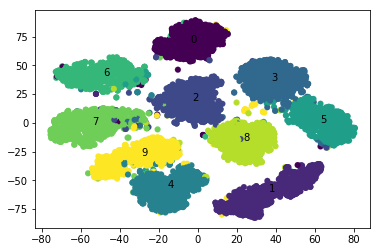

In [4]:
for i in xrange(10):
    x, y = embedding_2d[y_true == i, :].mean(axis=0)
    plt.text(x, y, str(i))
plt.show()